# To Do:
* ~~Histogram - apparent magnitude (iband)~~
* SED Adjustments(?)
* ~~How band widths convert to redshift scale~~
* ~~What each object spectra looks like for a specific redshift bin (big difference between mean and median)~~

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import astropy.cosmology
from astropy.cosmology import Planck15 as cosmo
import scipy.stats

In [2]:
# MAY NEED ADJUSTING DEPEDNING ON DEVICE/OS RUNNING
data = pd.read_csv("../../Data/PAUS_866.csv")
data['band'] = data['band'].str.slice(start=2).astype(int)
# Converts 'band' column from type string to int

/home/baldimort/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3018: DtypeWarning: Columns (57) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
'''z_photo = []
z_spec = []

object_ids = data.loc[data['ref_id_1'].notna()]['ref_id_1'].unique()

for i in object_ids:
    try:
        z_photo.append(data.loc[data['ref_id_1'] == i]['zb'].unique()[0])
        z_spec.append(data.loc[data['ref_id_1'] == i]['zspec'].unique()[0])
    except Exception as e:
        print(e,"\nFailed! Object id: {}".format(i))
        continue
        
    
datasetup = {'ref_id_1':object_ids,'z_photo':z_photo,'z_spec':z_spec}
objects_zbs_df = pd.DataFrame(datasetup)

objects_zbs_df.to_pickle("../../Data/Object_zs_zp2.pkl","gzip")'''

# Generating df with object_id - zphoto - zspec
# Has been saved to data folder so can be read from "Object_zs_zp.pkl.gz"

objects_zbs_df = pd.read_pickle("../../Data/Object_zs_zp.pkl.gz")

# objects_zbs_df


In [5]:
objects_zbs_df.shape #choeck z_spec column

(47233, 3)

In [5]:
data.columns.values

array(['ref_id_1', 'zb', 'odds', 'pz_width', 'zb_mean', 'chi2_1',
       'n_band', 'ebv', 'qz', 'best_run', 'production_id_1',
       'production_id_2', 'ref_id_2', 'band', 'flux', 'flux_error',
       'chi2_2', 'n_coadd', 'run', 'GroupID_1', 'GroupSize_1', 'paudm_id',
       'ra', 'dec', 'zp_gal', 'zl68_gal', 'zu68_gal', 'zl99_gal',
       'zu99_gal', 'zp_sec', 'dchi', 'imag', 'ei', 'i_auto', 'nbfilt',
       'mod_gal', 'type', 'umag', 'bmag', 'vmag', 'gmag', 'rmag', 'zmag',
       'icmag', 'jmag', 'kmag', 'mv', 'ebv_gal', 'ebv_int', 'acs_a_image',
       'acs_b_image', 'acs_theta_image', 'acs_mag_auto',
       'acs_magerr_auto', 'zspec', 'conf', 'f814w', 'zfits', 'r50',
       'sersic_n_gim2d', 'GroupID', 'GroupSize'], dtype=object)

In [6]:
data.shape

(2473521, 62)

#  
#  
# SED

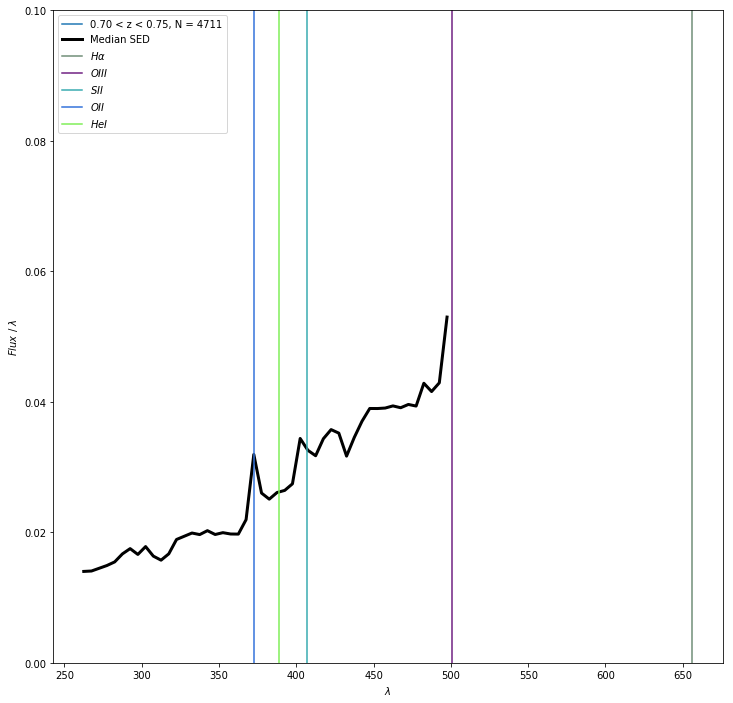

In [10]:
#bins = [[0.1,0.27],[0.2,0.38],[0.3,0.5],[0.4,0.61],[0.5,0.72],[0.6,0.84],[0.7,0.96],[0.8,1.07],[0.9,1.19],[1,1.3],[1.1,1.42]]
bins = [[0.7,0.75]]
fig = plt.figure(figsize=(12,12))

band_obsframe = data['band']/(data['zb']+1)
# print(band_obsframe.min(),band_obsframe.max())
band_bins = np.arange(200,860,5)

# print(band_obsframe,band_bins)
all_means = []
# print(data.loc[(data['imag']==0)|(data['rmag']==0)|(data['odds']<0)]['flux'])


for z_bin in bins:
    lamb_sample = band_obsframe.loc[(data['zb'] >= z_bin[0]) & (data['zb'] <= z_bin[1])] #<---- remove rmgag=imag=0 and odds<0 results
    flux_sample = data.loc[(data['zb'] >= z_bin[0]) & (data['zb'] <= z_bin[1])]['flux']
    
#     flux_sample = 10**((26-flux_sample)/2.5) #<---- AB mag to flux conversion
    
    N_objects = data.loc[(data['zb'] >= z_bin[0]) & (data['zb'] <= z_bin[1])]['ref_id_1'].unique().size
    
    digitized = np.digitize(lamb_sample,band_bins)
    binned_means = [np.nanmedian(flux_sample[digitized == i]) for i in range(1,len(band_bins))]
    all_means.append(binned_means/(band_bins[1:]+band_bins[:-1])*2) #flux(in AB mags)/band wl
    
    
    plt.plot((band_bins[1:]+band_bins[:-1])/2,np.array(binned_means)/(band_bins[1:]+band_bins[:-1])*2,\
             label="{:.02f} < z < {:.02f}, N = {}".format(z_bin[0],z_bin[1],N_objects)) #flux(in AB mags)/500 band wl

# print(np.array(all_means))
plt.plot((band_bins[1:]+band_bins[:-1])/2,np.nanmedian(np.array(all_means),axis=0),'k-',linewidth=3,label="Median SED")

emis_lines = [[656.28,r'$H\alpha$'],[500.7,r'$OIII$'],[407.2,r'$SII$'],[372.8,r"$OII$"],[388.9,r'$HeI$']]
for line in emis_lines:
    random_ints = np.random.randint(256,size=3)
    plt.axvline(line[0],label=line[1],color='#{}{}{}'.\
                format(hex(random_ints[0])[2:].zfill(2),hex(random_ints[1])[2:].zfill(2),hex(random_ints[2])[2:].zfill(2)))

plt.xlabel(r'$\lambda$')
plt.ylabel(r'$Flux\ /\ \lambda$')
plt.legend()
plt.ylim([0,0.1])
#plt.xlim([200,680])
plt.show()


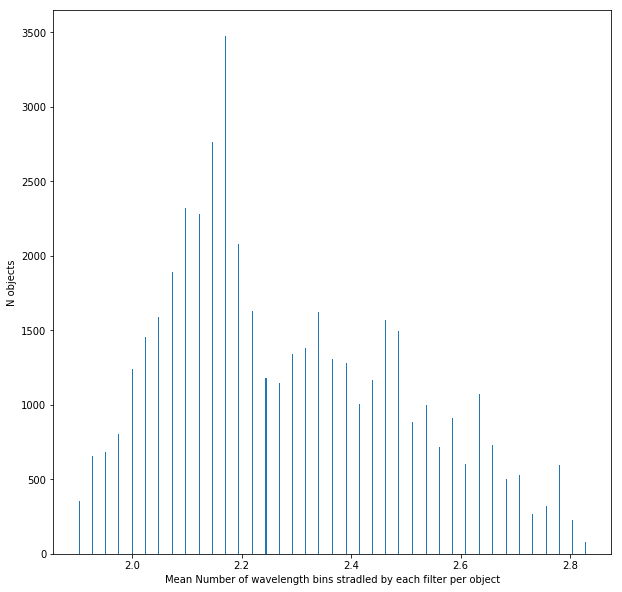

In [8]:
z_bin = [0.1,1.2]
sample_ = objects_zbs_df.loc[(objects_zbs_df['z_photo'] >= z_bin[0]) & (objects_zbs_df['z_photo'] <= z_bin[1])]
object_ids_ = sample_['ref_id_1']

# data['band'].unique().size
band_boundaries_ = np.arange(445,856,10) #set up boundaries of observing bands --- CHECK THIS!
# band_boundaries.size


band_boundaries_ = np.tile(band_boundaries_,(object_ids_.size,1))
shifted_boundaries_ = band_boundaries_ / (1+sample_['z_photo'].values[:,None])


band_boundaries_binned = np.digitize(shifted_boundaries_, band_bins) #<------

mean_bin_number = np.mean(band_boundaries_binned[:,1:] - band_boundaries_binned[:,:-1] + 1,axis=1)


plt.figure(figsize=(10,10))
plt.hist(mean_bin_number,500)
plt.xlabel('Mean Number of wavelength bins stradled by each filter per object')
plt.ylabel('N objects')
plt.show()

In [31]:
np.savetxt('test.txt',band_boundaries_binned,fmt='%.0f',newline='\n\n')


# Histogram - apparent mag (iband)

/home/baldimort/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/baldimort/.local/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


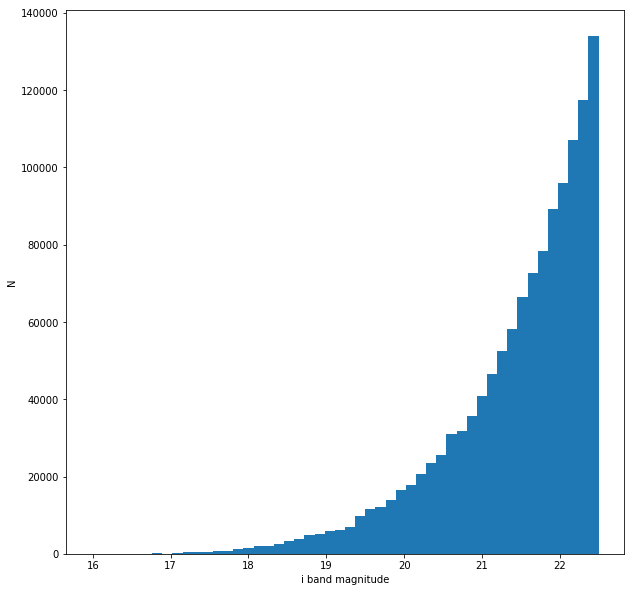

In [7]:
plt.figure(figsize=(10,10))
imags = data.loc[data['imag'] != 0]['i_auto']
plt.hist(imags,bins=50)
plt.xlabel('i band magnitude')
plt.ylabel('N')
plt.show()

#remove repeats!!!

# Flux for each object in specific redshift bin

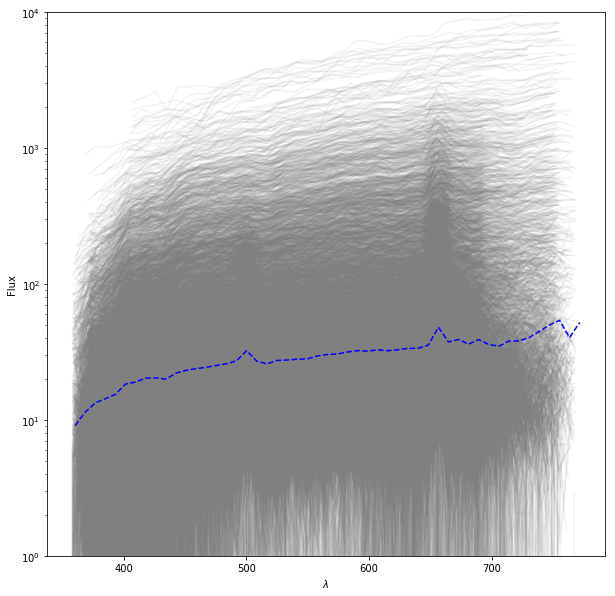

In [15]:
redshift_bin = [0.1,0.27]
data_samp = data.loc[ (data['zb']>=redshift_bin[0]) & (data['zb']<=redshift_bin[1]) ]
data_samp_band = data_samp['band']/(data_samp['zb']+1) #Redshift correction

object_ids_ = data_samp['ref_id_1'].unique()

plt.figure(figsize=(10,10))

for object_id in object_ids_:
    fluxs = data_samp.loc[ data_samp['ref_id_1'] == object_id ]['flux']
    bands = data_samp_band.loc[ data_samp['ref_id_1'] == object_id ]
    plt.plot(bands,fluxs,'gray',alpha=0.1)

    
digitized = np.digitize(data_samp_band,band_bins)
binned_means = [np.nanmedian(data_samp.loc[digitized == i]['flux']) for i in range(1,len(band_bins))]

plt.plot((band_bins[1:]+band_bins[:-1])/2,binned_means,'b--')

plt.xlabel(r'$\lambda$')
plt.ylabel(r'Flux')
plt.yscale('log')
plt.ylim([10**0,10**4])
plt.show()